In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np

import veritas
import xgboost as xgb
import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Load MNIST from OpenML

In [3]:
X, y_mc = datasets.fetch_openml(data_id=554, return_X_y=True, as_frame=False, parser='auto')
X = X.astype(veritas.FloatT)

In [4]:
y = y_mc.astype(int)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=6)
num_classes = 10

# Train an XGBoost model

In [5]:
# NOTE performances here are pretty bad, we used small trees to show practicalities of the new methods/structures
params = {
    "n_estimators": 10,
    "num_class": num_classes,
    "objective": "multi:softmax",
    "eval_metric": "merror",
    "multi_strategy": "multi_output_tree",
    
    "tree_method": "hist",
    "seed": 135,
    "max_depth": 3,#7,
    "learning_rate": 0.5,
    "colsample_bynode": 0.75,
    "subsample": 0.5
}
model = xgb.XGBClassifier(**params)

t = time.time()
model.fit(X, y)
print(f"XGB trained in {time.time()-t} seconds")

XGB trained in 9.493682384490967 seconds


In [6]:
ytrain_pred = model.predict(xtrain)
ytest_pred = model.predict(xtest)
acc_train = accuracy_score(ytrain, ytrain_pred)
acc_test = accuracy_score(ytest, ytest_pred)

print(f"Train acc: {acc_train:.3f}, test acc: {acc_test:.3f} wrt true labels")

Train acc: 0.821, test acc: 0.822 wrt true labels


# Convert multiclass XGB to a multiclass AddTree

In [7]:
at = veritas.get_addtree(model, silent=True)

In [8]:
print(at[0])

Node(id=0, split=[F409 < 1], sz=15, left=1, right=2)
├─ Node(id=1, split=[F434 < 1], sz=7, left=3, right=4)
│  ├─ Node(id=3, split=[F455 < 1], sz=3, left=5, right=6)
│  │  ├─ Leaf(id=5, sz=1, value=[0.388856, -0.254628, -0.0554982, 0.171288, -0.25094, 0.418357, 0.0403791, 0.0108784, -0.22144, -0.247253])
│  │  └─ Leaf(id=6, sz=1, value=[2.08205, -0.276259, -0.193254, -0.245987, -0.246963, -0.198137, -0.193254, -0.220597, -0.263564, -0.244033])
│  ├─ Node(id=4, split=[F375 < 1], sz=3, left=7, right=8)
│  │  ├─ Leaf(id=7, sz=1, value=[-0.267328, 1.647, 0.0594657, -0.191136, -0.242327, -0.208993, -0.181016, -0.195898, -0.157206, -0.262566])
│  │  └─ Leaf(id=8, sz=1, value=[-0.241288, -0.0596621, -0.0881732, 0.0374868, -0.209609, 0.6151, 0.0058078, -0.267687, 0.422914, -0.214889])
├─ Node(id=2, split=[F155 < 1], sz=7, left=9, right=10)
│  ├─ Node(id=9, split=[F239 < 1], sz=3, left=11, right=12)
│  │  ├─ Leaf(id=11, sz=1, value=[-0.271884, -0.162359, -0.211955, -0.242264, 1.37995, -0.224355

In [9]:
# By default, Veritas optimizes the 0th class. One can swap classes into the first position in order to optimize other classes
at.swap_class(1)
# the method simply swaps the order of the classes in the leaf value vectors: now in position 0 we have values related to class 1
# check first tree as example:
print(at[0])

Node(id=0, split=[F409 < 1], sz=15, left=1, right=2)
├─ Node(id=1, split=[F434 < 1], sz=7, left=3, right=4)
│  ├─ Node(id=3, split=[F455 < 1], sz=3, left=5, right=6)
│  │  ├─ Leaf(id=5, sz=1, value=[-0.254628, 0.388856, -0.0554982, 0.171288, -0.25094, 0.418357, 0.0403791, 0.0108784, -0.22144, -0.247253])
│  │  └─ Leaf(id=6, sz=1, value=[-0.276259, 2.08205, -0.193254, -0.245987, -0.246963, -0.198137, -0.193254, -0.220597, -0.263564, -0.244033])
│  ├─ Node(id=4, split=[F375 < 1], sz=3, left=7, right=8)
│  │  ├─ Leaf(id=7, sz=1, value=[1.647, -0.267328, 0.0594657, -0.191136, -0.242327, -0.208993, -0.181016, -0.195898, -0.157206, -0.262566])
│  │  └─ Leaf(id=8, sz=1, value=[-0.0596621, -0.241288, -0.0881732, 0.0374868, -0.209609, 0.6151, 0.0058078, -0.267687, 0.422914, -0.214889])
├─ Node(id=2, split=[F155 < 1], sz=7, left=9, right=10)
│  ├─ Node(id=9, split=[F239 < 1], sz=3, left=11, right=12)
│  │  ├─ Leaf(id=11, sz=1, value=[-0.162359, -0.271884, -0.211955, -0.242264, 1.37995, -0.224355

# Train a better model, extract one base example

In [10]:
# same as above, with deeper trees
params["max_depth"] = 5
model = xgb.XGBClassifier(**params)

t = time.time()
model.fit(X, y)
print(f"XGB trained in {time.time()-t} seconds")

ytrain_pred = model.predict(xtrain)
ytest_pred = model.predict(xtest)
acc_train = accuracy_score(ytrain, ytrain_pred)
acc_test = accuracy_score(ytest, ytest_pred)
print(f"Train acc: {acc_train:.3f}, test acc: {acc_test:.3f} wrt true labels")

XGB trained in 14.965305805206299 seconds
Train acc: 0.902, test acc: 0.899 wrt true labels


In [11]:
at = veritas.get_addtree(model, silent=True)

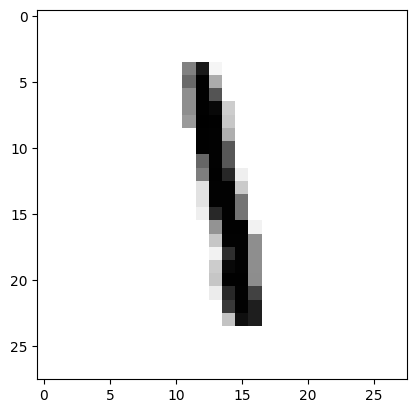

In [12]:
# select one example of class 1
number_of_adv_examples = 1

rng = np.random.default_rng(seed=6)
xtest0 = xtest[ytest_pred==1, :]
subset = xtest0[rng.choice(range(xtest0.shape[0]), number_of_adv_examples), :].astype(veritas.FloatT)

plt.imshow((subset[0, :]).reshape((28,28)), cmap="binary")

In [13]:
# test outputs for chosen base example
base_example = subset[0, :]
y_xgb = model.predict_proba(subset)
y_ats = at.predict(subset)
y_xgb.round(3), y_ats.round(3)

(array([[0.002, 0.947, 0.003, 0.007, 0.005, 0.005, 0.004, 0.005, 0.01 ,
         0.012]], dtype=float32),
 array([[0.002, 0.947, 0.003, 0.007, 0.005, 0.005, 0.004, 0.005, 0.01 ,
         0.012]]))

# MAX_MAX example: targeted attack - one adv. ex. per class

In [14]:
# idea: we start with a base example of class 1
# we try to generate an adversarial example classfied in each of the other classes (0, 2, 3, ..., 9)
# a soltuion for class 0 is the solution to the maximization problem: 
# max_x [ T_0(x) - max_c (T_c(x)) ]
# i.e., class0 is preferred over each other class

In [15]:
### MAX_MAX multiclass

adv_examples = []
atc = at.copy()
eps  = 5

# once per class (class0 --> class1, class0 --> class2, ...)
for c in range(0, num_classes):
    if c==1:
        continue
        
    print(c)
    atc.swap_class(c)

    config = veritas.Config(veritas.HeuristicType.MULTI_MAX_MAX_OUTPUT_DIFF)
    config.ignore_state_when_worse_than = 0.0
    config.max_memory = 16*1024*1024*1024
    prune_box = [veritas.Interval(max(0.0, x-eps), min(255, x+eps)) for x in base_example]
    s = config.get_search(atc, prune_box)

    tstart = time.time()
    while s.num_solutions() == 0:
        stop_reason = s.steps(1000)
        #print(s.stats.num_steps, stop_reason)
        if stop_reason != veritas.StopReason.NONE:
            break
        
    tstop = time.time()

    atc.swap_class(c) #go back to original addtree for evaluation

    if s.num_solutions() > 0:
        sol = s.get_solution(0)
        adv_example = veritas.get_closest_example(sol, base_example, 1e-5)

        res = {"c": c, "adv_example": adv_example, "base_example": base_example}

        print(at.predict(base_example)[0].round(2))
        print(at.predict(adv_example)[0].round(2))
        #print(sol.output)
        print()

        adv_examples.append(res)
        
    else:
        print("no adversarial examples found for", c)

    #break

0
no adversarial examples found for 0
2
[0.   0.95 0.   0.01 0.01 0.   0.   0.   0.01 0.01]
[0.   0.02 0.89 0.02 0.02 0.01 0.01 0.01 0.01 0.01]

3
[0.   0.95 0.   0.01 0.01 0.   0.   0.   0.01 0.01]
[0.   0.   0.   0.99 0.   0.   0.   0.   0.   0.  ]

4
[0.   0.95 0.   0.01 0.01 0.   0.   0.   0.01 0.01]
[0.01 0.01 0.01 0.02 0.88 0.01 0.02 0.01 0.02 0.02]

5
[0.   0.95 0.   0.01 0.01 0.   0.   0.   0.01 0.01]
[0.   0.   0.   0.   0.   0.99 0.   0.   0.   0.  ]

6
[0.   0.95 0.   0.01 0.01 0.   0.   0.   0.01 0.01]
[0.01 0.02 0.01 0.02 0.02 0.02 0.88 0.01 0.01 0.01]

7
[0.   0.95 0.   0.01 0.01 0.   0.   0.   0.01 0.01]
[0.01 0.03 0.05 0.05 0.02 0.04 0.01 0.7  0.04 0.05]

8
[0.   0.95 0.   0.01 0.01 0.   0.   0.   0.01 0.01]
[0.01 0.03 0.04 0.03 0.03 0.02 0.01 0.04 0.76 0.03]

9
[0.   0.95 0.   0.01 0.01 0.   0.   0.   0.01 0.01]
[0.   0.01 0.01 0.02 0.03 0.03 0.01 0.02 0.03 0.84]



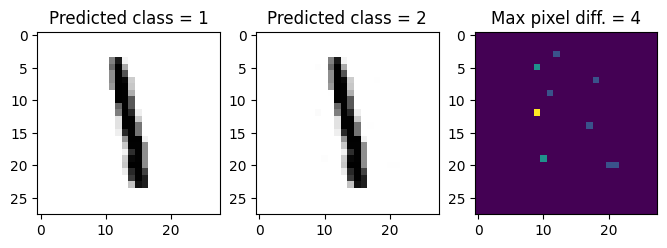

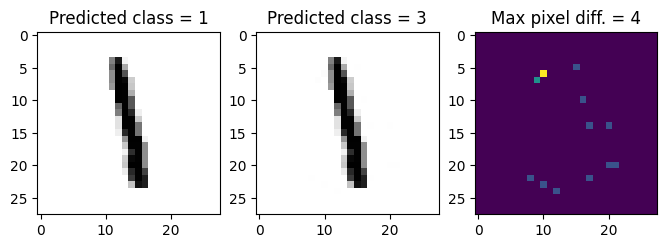

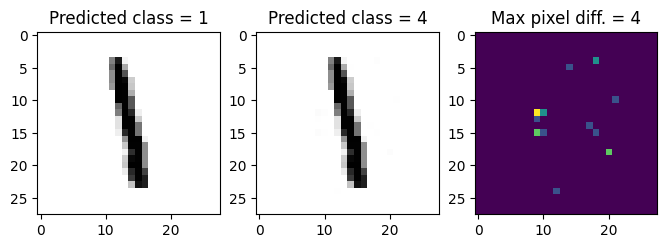

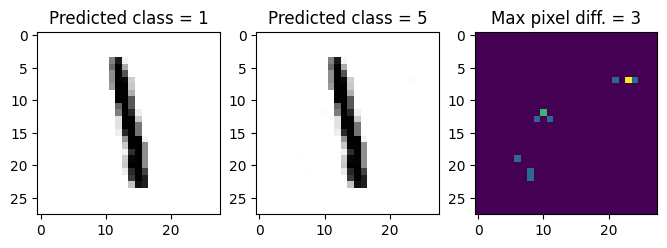

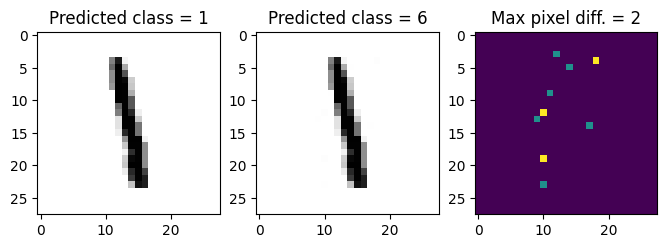

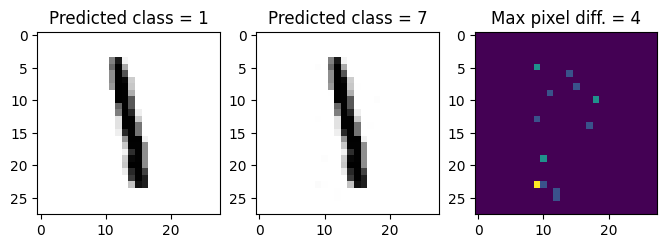

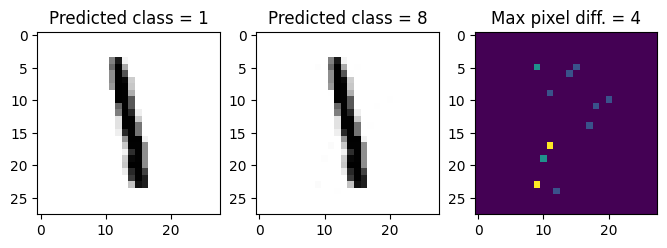

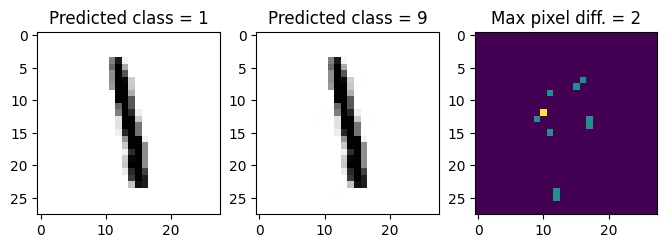

In [16]:
for i, res in enumerate(adv_examples):
    fig, ax = plt.subplots(1, 3, figsize=(8, 3))
    ax[0].imshow((res["base_example"]).reshape((28,28)), cmap="binary")
    base_class = np.argmax(at.eval(res["base_example"])[0])
    ax[0].set_title(f"Predicted class = {base_class}")
    adv_class = np.argmax(at.eval(res["adv_example"])[0])
    ax[1].imshow((res["adv_example"]).reshape((28,28)), cmap="binary")
    ax[1].set_title(f"Predicted class = {adv_class}")
    ax[2].imshow((res["adv_example"]-res["base_example"]).reshape((28,28)))
    max_diff = np.max(np.abs(res["base_example"]-res["adv_example"]))
    ax[2].set_title(f"Max pixel diff. = {int(max_diff)}")